# Falta fazer
## Relatório
## Documentação

In [1]:
# import das bibliotecas
import os
import pandas as pd
import random
import time
from greedy_filter import *
from math import inf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
# definicao das constantes
PATH_EXCEL = os.getcwd() + '/excel_files/'

Estruturas que irao armazenar os dataframes com o histórico de preços das ações.
1. dict_excels: dicionario onde a chave é o nome da ação e o valor da chave é o dataframe
2. filenames: lista com o nome dos arquivos
3. excels: lista com os dataframes

In [3]:
dict_excels = {}
filenames = []
excels = []
for filename in os.listdir(PATH_EXCEL):
    filenames.append(filename[:filename.find('.')])
    excels.append(pd.read_excel(PATH_EXCEL + filename).sort_values(by=['Exchange Date']).reset_index(drop=True))
    dict_excels[filename[:filename.find('.')]] = (pd.read_excel(PATH_EXCEL + filename).sort_values(by=['Exchange Date']).reset_index(drop=True))

## Modelagem do problema
### Algoritmo Genético 1 - Escolha dos Parâmetros das Regras de Filtro
1. Gene: cada um dos parâmetros do filtro
    1. x - porcentagem de variação: porcentagem acima/abaixo da ultima subida ou queda
       1. varia de 0 a 1
       2. varia de 0.01 a 0.10
    2. h - hold days: após um sinal de compra/venda esperamos por h dias
       1. varia de 1 até o número de dias entre a data atual e a data onde acabam as informacoes
       2. varia de 1 até 30
    3. d - delay days: após receber um sinal ignora-se os próximos d dias
       1. varia de 1 até o número de dias entre a data atual e a data onde acabam as informacoes
       2. varia de 1 até 30
    4. p - previous days: olha-se p dias para tomar uma decisão
       1. varia de 0 até o número de dias transcorridos até o momento
       2. varia de 30 até o número máximo de dias
2. Cromossomo: conjunto de parâmetros
    1. Estrutura usada: lista com os parâmetros &rarr; [x, h, d, p]
3. População: conjunto de cromossomos
    1. Tamanho da População:
4. Mutação:
    1. taxa de mutação:
5. Crossover:
    1. taxa de crossover:
6. Critério de Parada:
7. Seleção:
    1. Fitness: cálculo do lucro obtido por cada cromossomo
    2. Técnica de Seleção:
        1. Técnica 1:
        2. Técnica 2:

Funções para realizar o crossover entre dois cromossomos

In [4]:
def crossover(chromosome1, chromosome2):
    """
        Funcao para realizar o crossover entre dois cromossomos
        :param: chromosome1 - cromossomo pai
        :param: chromosome2 - cromossomo mae
        :return: new_chromosome1 - primeiro filho gerado no crossover
        :return: new_chromosome2 - segundo filho gerado no crossover
    """
    # escolhe um gene aleatorio para realizar o crossover
    rand = random.randint(1,len(chromosome1) - 1)

    # gera os dois novos cromossomos
    new_chromosome1 = chromosome1[:rand] + chromosome2[rand:]
    new_chromosome2 = chromosome2[:rand] + chromosome1[rand:]
    
    return new_chromosome1, new_chromosome2

def crossover2(chromosome1, chromosome2):
    """
        Funcao para realizar o crossover entre dois cromossomos com 2 pontos de corte
        :param: chromosome1 - cromossomo pai
        :param: chromosome2 - cromossomo mae
        :return: new_chromosome1 - primeiro filho gerado no crossover
        :return: new_chromosome2 - segundo filho gerado no crossover
    """
    # escolhe um gene aleatorio para realizar o crossover
    rand = random.randint(1,len(chromosome1) - 2)
    rand2 = random.randint(rand+1, len(chromosome1) - 1)
    # gera os dois novos cromossomos
    new_chromosome1 = chromosome1[:rand] + chromosome2[rand:rand2] + chromosome1[rand2:]
    new_chromosome2 = chromosome2[:rand] + chromosome1[rand:rand2] + chromosome2[rand2:]
    
    return new_chromosome1, new_chromosome2

Funções para realizar a mutação de um cromossomo

In [5]:
def mutation(chromossome):
    """
        Funcao para realizar a mutacao de um dado cromossomo
        :param: chromossome - cromossomo que ira passar pelo processo de mutacao
        :param: today_index - indice da tabela referente a data atual da acao
        :param: last_day_index - indice da tabela referente a ultima data da qual se tem informacao da acao
        :return: new_chromossome - novo cromossomo apos o processo de mutacao
    """
    # faz a copia do cromossomo original
    new_chromossome = chromossome
    
    # escolhe, aleatoriamente, um gene para ser alterado
    gene_initial_position = random.randint(0,len(chromossome) - 1)
    gene_final_position = random.randint(gene_initial_position, len(chromossome) - 1)
    
    # modifica o conjunto de genes escolhidos seguindo, como unica regra, os valores que eles podem assumir
    for i in range(gene_initial_position, gene_final_position + 1):
        if i == 0:
            new_chromossome[0] = random.uniform(0.01,0.10)
        elif i == 1:
            new_chromossome[1] = random.randint(1,30)
        elif i == 2:
            new_chromossome[2] = random.randint(1,30)
        elif i == 3:
            new_chromossome[3] = random.randint(30,500)
        else:
            raise Exception('Gene inexistente no cromossomo!')
        
    return new_chromossome

def mutation_v2(chromossome):
    """
        Funcao para realizar a mutacao de um dado cromossomo
        :param: chromossome - cromossomo que ira passar pelo processo de mutacao
        :return: new_chromossome - novo cromossomo apos o processo de mutacao
    """
    # faz a copia do cromossomo original
    new_chromossome = chromossome
    
    # escolhe, aleatoriamente, um gene para ser alterado
    gene_position = random.randint(0,len(chromossome) - 1)
    
    # modifica o gene escolhido seguindo, como unica regra, os valores que ele pode assumir
    if gene_position == 0:
        new_chromossome[0] = random.uniform(0.01,0.10)
    elif gene_position == 1:
        new_chromossome[1] = random.randint(1,30)
    elif gene_position == 2:
        new_chromossome[2] = random.randint(1,30)
    elif gene_position == 3:
        new_chromossome[3] = random.randint(30,500)
    else:
        raise Exception('Gene inexistente no cromossomo!')
        
    return new_chromossome

Função para realizar a inicialização randômica de uma população

In [6]:
def create_population(population_size):
    """
        Funcao para criar uma populacao randomica de cromossomos
        :param: population_size - tamanho da populacao que sera criada
        :return: population - nova populacao
    """
    population = []
    for i in range(0, population_size):
        population.append([random.uniform(0,0.1), random.randint(1,30), random.randint(1,30), random.randint(1,500)])
        
    return population

In [7]:
def fitness(np_array, chromossomes, budget):
    """
        Funcao para calcular o lucro de cada um dos cromossomos de uma dada populacao
        :param: np_array - conjunto de dados de determinada acao
        :param: chromossomes - lista de cromossomos que sera avaliada
        :param: budget - dinheiro inicial do problema
        :return: fit_chromossomes - matriz com os cromossomos e o lucro(em porcentagem) obtido por eles
    """
    fit_chromossomes = []
    for chromossome in chromossomes:
        money = greedy_filter_rule(np_array, chromossome, budget)
        fit_chromossomes.append([chromossome, (money-budget)/budget])
        
    return fit_chromossomes

In [8]:
def selection(stock_value, list_chromossomes, budget, cut_size):
    """
        :param: stock_value - 
        :param: list_chromossomes - 
        :param: budget - 
        :param: cut_size - 
        
        :return: new_generation - 
        :return: fitness_array - 
    """
    fitness_array = fitness(stock_value, list_chromossomes, budget)
    fitness_array.sort(key=lambda x: x[1], reverse = True)
    new_generation = []
    for i in range (0,cut_size):
        new_generation.append(fitness_array[i][0])
    return new_generation, fitness_array[:cut_size]

In [9]:
def roulette_selection(stock_value, list_chromossomes, budget, cut_size):
    """
        :param: stock_value - 
        :param: list_chromossomes - 
        :param: budget - 
        :param: cut_size - 
        
        :return: new_population - 
        :return: cut_size - 
    """
    fitness_array = fitness(stock_value, list_chromossomes, budget)
    fitness_array = linear_normalization(fitness_array)

    adds_skills = 0
    for fit in fitness_array:
        adds_skills = adds_skills + fit[1]
    
    new_population = []
    for i in range(cut_size):
        r = random.uniform(0, adds_skills)
        temp_soma = 0
        for fit in fitness_array:
            temp_soma = temp_soma + fit[1]
            if temp_soma >= r:
                new_population.append(fit[0])
                break
    return new_population, fitness(stock_value, new_population, budget)

In [10]:
def stop_criterion(old_population, new_population, limit_to_converge):
    """
        :param: old_population - populacao ao iniciar a iteracao
        :param: new_population - populacao ao fim da iteracao
        :param: limit_to_converge - limiar abaixo do qual iremos considerar que ambas as pop convergem

        :return: True se for para parar, False c.c.
    """
    soma_old = 0
    for x in old_population:
        soma_old = soma_old + x[1]

    soma_new = 0
    for x in new_population:
        soma_new = soma_new + x[1]
    
    media_old = soma_old / len(old_population)
    media_new = soma_new / len(new_population)
    
    if abs(media_new - media_old) < limit_to_converge:
        return True
    else:
        return False

In [11]:
def generate_children(old_generation, crossover_function, crossover_rate):
    """
        :param: old_generation - 
        :param: crossover_function - 
        :param: crossover_rate - 
        
        :return: children - 
    """
    size_generation = len(old_generation)
    number_to_crossover = int(size_generation * crossover_rate)
    random.shuffle(old_generation)
    children = []
    for i in range (number_to_crossover):
        for j in range (i+1, number_to_crossover):
            new_chromossome1, new_chromossome2 = crossover_function(old_generation[i], old_generation[j])
            children.append(new_chromossome1)
            children.append(new_chromossome2)
    return children

In [12]:
def mutation_chromossome(chromossomes, mutation_function, mutation_rate):
    """
        :param: chromossomes - 
        :param: mutation_function - 
        :param: mutation_rate - 
        
        :return: chromossomes - 
    """
    number_chromossomes_to_mutate = int(len(chromossomes) * mutation_rate)
    random.shuffle(chromossomes)
    for i in range (0,number_chromossomes_to_mutate):
        chromossomes[i] = mutation_function(chromossomes[i])
    return chromossomes
    

In [20]:
def evolutionary_strategy1(stock_values, first_population, budget, crossover_function, mutation_func,delta, mutation_rate, crossover_rate, min_iteration_converge):
    """
        :param: stock_values - 
        :param: first_population - 
        :param: budget - 
        :param: crossover_function - 
        :param: delta -
        
        :return: old_population - 
    """
    flag = False
    iteration = 0
    old_population = first_population
    while (not flag):
        fitness_old_population = fitness(stock_values, old_population, budget)
        children = generate_children(first_population, crossover_function, crossover_rate)
        parents_and_children = old_population + children
        chromossomes_parents_children_mutated = mutation_chromossome(parents_and_children, mutation_func, mutation_rate)
        new_population, fitness_new_population = selection(stock_values, chromossomes_parents_children_mutated, budget, len(old_population))
        flag = (stop_criterion(fitness_old_population, fitness_new_population, delta) and iteration > min_iteration_converge)
        iteration = iteration + 1
        old_population = new_population
    return old_population
        

In [14]:
def linear_normalization(fitness_population, increment=20):
    pop_size = len(fitness_population)
    fitness_population = sorted(fitness_population, key=lambda x: x[1], reverse = False)
    min_value = 1
    max_value = 201
    normalized_fitness = []
    for i in range(pop_size):
        temp_fit = min_value + ((max_value - min_value)/(pop_size - 1)) * (i)
        normalized_fitness.append([fitness_population[i][0],temp_fit])
    
    return normalized_fitness

In [15]:
def evolutionary_strategy2(stock_values, first_population, budget, crossover_function, mutation_func,delta, mutation_rate, crossover_rate, min_iteration_converge):
    """
        :param: stock_values - 
        :param: first_population - 
        :param: budget - 
        :param: crossover_function - 
        :param: mutation_func - 
        :param: delta -
        
        :return: old_population - 
    """
    flag = False
    iteration = 0
    old_population = first_population
    while (not flag):
        fitness_old_population = fitness(stock_values, old_population, budget)
        children = generate_children(first_population, crossover_function, crossover_rate)
        parents_and_children = old_population + children
        chromossomes_parents_children_mutated = mutation_chromossome(parents_and_children, mutation_func, mutation_rate)
        chromossomes_parents_children_mutated = random.sample(chromossomes_parents_children_mutated, len(chromossomes_parents_children_mutated))
        new_population, fitness_new_population = roulette_selection(stock_values, chromossomes_parents_children_mutated, budget, len(old_population))
        flag = (stop_criterion(fitness_old_population, fitness_new_population, delta) and iteration > min_iteration_converge)
        iteration = iteration + 1
        old_population = new_population
    return old_population



# Let's play - Igor

## Primeiro conjunto de testes

### Variaveis que serão usadas para a primeira população
Para as ações da Alphabet serão testados:
1. Dados Fixos:
    1. Budget &rarr; 10.000,00
    2. Delta para considerar convergência &rarr; 0.01
2. Dados variáveis:
    1. População:
        1. Para uma população de 100 e outra de 1000, testamos:
            1. Duas funções de Crossover:
                1. Taxa de Crossover &rarr; 0.3
                2. Taxa de Crossover &rarr; 0.8
            2. Duas funções de Mutação:
                1. Taxa de Mutação &rarr; 0.3
                2. Taxa de Mutação &rarr; 0.8


#### Primeira iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.01
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3

Dados fixos que serão usados para todas as iterações de 100 cromossomos

In [16]:
population_len = 100
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 3
np_array = excels[5].values # Irá utilizar a primeira lista de valores da bolsa
chromossomes = create_population(population_len)

Aplicação da estratégia evolucionária

In [17]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_temp = evolutionary_strategy1(np_array, chromossomes, budget, crossover, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

#### Segunda iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.8
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3

In [165]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.8

In [167]:
begin_time = time.time()
best_chromossomes_2 = evolutionary_strategy1(np_array, chromossomes, budget, crossover, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

#### Terceira iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.8

In [ ]:
# Dados variáveis
mutation_rate = 0.8
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_3 = evolutionary_strategy1(np_array, chromossomes, budget, crossover, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

#### Quarta iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3

In [ ]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_4 = evolutionary_strategy1(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

#### Quinta iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.8
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3

In [ ]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.8

In [ ]:
begin_time = time.time()
best_chromossomes_5 = evolutionary_strategy1(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

#### Sexta iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.8

In [ ]:
# Dados variáveis
mutation_rate = 0.8
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_6 = evolutionary_strategy1(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

#### Sétima iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation_v2
    1. Taxa &rarr; 0.3

In [ ]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_7 = evolutionary_strategy1(np_array, chromossomes, budget, crossover, mutation_v2, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

#### Oitava iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.8
5. Mutação &rarr; mutation_v2
    1. Taxa &rarr; 0.3

In [ ]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.8

In [ ]:
begin_time = time.time()
best_chromossomes_8 = evolutionary_strategy1(np_array, chromossomes, budget, crossover, mutation_v2, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

#### Nona iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation_v2
    1. Taxa &rarr; 0.8

In [ ]:
# Dados variáveis
mutation_rate = 0.8
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_9 = evolutionary_strategy1(np_array, chromossomes, budget, crossover, mutation_v2, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

### Segundo conjunto de Testes

#### Primeiro teste - Crescimento da população

Em um segundo momento será feito um teste visando avaliar o comportamento do tempo gasto pela função de acordo com o tamanho da população. Para tal, serão fixadas as taxas e funções de mutação que trouxeram os melhores resultados no primeiro conjunto de testes e iremos avaliar a população de um valor fixo. 
Parâmetros setados:
1. Budget &rarr; 10.000
2. Delta &rarr; 0.01
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3

In [110]:
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 3
np_array = excels[5].values # Irá utilizar a primeira lista de valores da bolsa
mutation_rate = 0.3
crossover_rate = 0.3

In [112]:
tempo_gasto = []
for i in range(10,110,10):
    print("Testando populacao de tamanho: " + str(i))
    chromossomes = create_population(i)
    begin_time = time.time()
    best_chromossomes_10 = evolutionary_strategy1(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
    tempo_gasto.append(round(time.time() - begin_time, 2))
    print("\t Tempo gasto: " + str(round(time.time() - begin_time, 2)))

Testando populacao de tamanho: 10
	 Tempo gasto: 35.13
Testando populacao de tamanho: 20
	 Tempo gasto: 78.9
Testando populacao de tamanho: 30
	 Tempo gasto: 238.56
Testando populacao de tamanho: 40
	 Tempo gasto: 207.65
Testando populacao de tamanho: 50
	 Tempo gasto: 243.23
Testando populacao de tamanho: 60
	 Tempo gasto: 455.52
Testando populacao de tamanho: 70
	 Tempo gasto: 1260.41
Testando populacao de tamanho: 80
	 Tempo gasto: 237.16
Testando populacao de tamanho: 90
	 Tempo gasto: 883.5
Testando populacao de tamanho: 100
	 Tempo gasto: 539.61


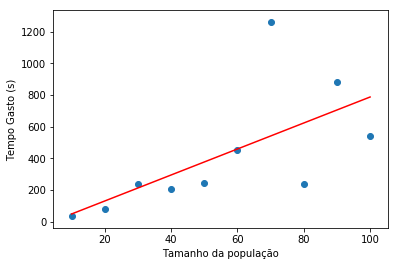

In [158]:
x = [10,20,30,40,50,60,70,80,90,100]
y = tempo_gasto

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit)

plt.plot(x,fit_fn(x), color='r', )
plt.scatter(x,y)
plt.xlabel("Tamanho da população")
plt.ylabel("Tempo Gasto (s)")
plt.show()

#### Segundo teste - Crescimento da Taxa de Mutação

O segundo teste feito nessa seção visa avaliar a performance da solução a medida em que aumentamos a taxa de mutação. Para tal, iremos fixar todos os parâmetros usados na estratégia evolutiva e iremos variar a taxa de mutação entre 0 e 1. É importante ressaltar que a fim de avaliar exclusivamente a influência da mutação iremos considerar uma taxa de crossover igual a 0.Parâmetros usados: 
1. Tamanho da População &rarr; 10
2. Budget &rarr; 10.000
3. Delta &rarr; 0.01
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.0
5. Mutação &rarr; mutation
    1. Taxa &rarr; variável de 0 a 1

In [187]:
population_size = 10
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 10
np_array = excels[5].values # Irá utilizar a primeira lista de valores da bolsa
crossover_rate = 0.0
chromossomes = create_population(population_size)

In [188]:
tempo_gasto_2 = []
i = 0.00
while i < 1.01:
    mutation_rate = i
    print("Testando taxa de: " + str(i))
    begin_time = time.time()
    temp = evolutionary_strategy1(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
    i = i + 0.10
    tempo_gasto_2.append(round(time.time() - begin_time, 2))
    print("\t Tempo gasto: " + str(round(time.time() - begin_time, 2)))

Testando taxa de: 0.0
	 Tempo gasto: 13.86
Testando taxa de: 0.1
	 Tempo gasto: 26.98
Testando taxa de: 0.2
	 Tempo gasto: 35.14
Testando taxa de: 0.30000000000000004
	 Tempo gasto: 22.74
Testando taxa de: 0.4
	 Tempo gasto: 44.51
Testando taxa de: 0.5
	 Tempo gasto: 42.04
Testando taxa de: 0.6
	 Tempo gasto: 30.33
Testando taxa de: 0.7
	 Tempo gasto: 31.43
Testando taxa de: 0.7999999999999999
	 Tempo gasto: 49.44
Testando taxa de: 0.8999999999999999
	 Tempo gasto: 35.41
Testando taxa de: 0.9999999999999999
	 Tempo gasto: 83.35


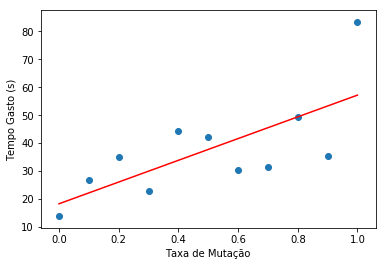

In [200]:
x_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_2 = tempo_gasto_2

fit = np.polyfit(x_2,y_2,1)
fit_fn = np.poly1d(fit)

plt.plot(x_2,fit_fn(x_2), color='r')
plt.scatter(x_2,y_2)
plt.xlabel("Taxa de Mutação")
plt.ylabel("Tempo Gasto (s)")
plt.show()

#### Terceiro teste - Crescimento da Taxa de Crossover

O terceiro teste feito nessa seção visa avaliar a performance da solução a medida em que aumentamos a taxa de crossover. Para tal, iremos fixar todos os parâmetros usados na estratégia evolutiva e iremos variar a taxa de crossover entre 0 e 1. É importante ressaltar que a fim de avaliar exclusivamente a influência do crossover iremos considerar uma taxa de mutação igual a 0. Parâmetros usados: 
1. Tamanho da População &rarr; 10
2. Budget &rarr; 10.000
3. Delta &rarr; 0.01
4. Crossover &rarr; crossover2
    1. Taxa &rarr; variável de 0 a 1
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0

In [178]:
population_size = 10
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 10
np_array = excels[5].values # Irá utilizar a primeira lista de valores da bolsa
mutation_rate = 0.0
chromossomes = create_population(population_size)

In [179]:
tempo_gasto_3 = []
i = 0.00
while i < 1.01:
    crossover_rate = i
    print("Testando taxa de: " + str(i))
    begin_time = time.time()
    temp = evolutionary_strategy1(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
    i = i + 0.10
    tempo_gasto_3.append(round(time.time() - begin_time, 2))
    print("\t Tempo gasto: " + str(round(time.time() - begin_time, 2)))

Testando taxa de: 0.0
	 Tempo gasto: 13.57
Testando taxa de: 0.1
	 Tempo gasto: 15.77
Testando taxa de: 0.2
	 Tempo gasto: 16.25
Testando taxa de: 0.30000000000000004
	 Tempo gasto: 46.33
Testando taxa de: 0.4
	 Tempo gasto: 63.97
Testando taxa de: 0.5
	 Tempo gasto: 61.23
Testando taxa de: 0.6
	 Tempo gasto: 62.35
Testando taxa de: 0.7
	 Tempo gasto: 110.53
Testando taxa de: 0.7999999999999999
	 Tempo gasto: 64.76
Testando taxa de: 0.8999999999999999
	 Tempo gasto: 249.47
Testando taxa de: 0.9999999999999999
	 Tempo gasto: 474.93


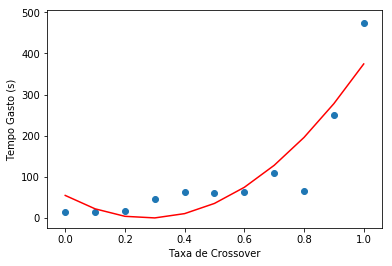

In [192]:
x_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_3 = tempo_gasto_3

fit = np.polyfit(x_2,y_3,2)
fit_fn = np.poly1d(fit)

plt.plot(x_2,fit_fn(x_2), color='r')
plt.scatter(x_2,y_3)
plt.xlabel("Taxa de Crossover")
plt.ylabel("Tempo Gasto (s)")
plt.show()